# ReachabilityAnalysis.jl (Part 2) : Nonlinear methods

### Contents

- [Roadmap](#Roadmap)
- [Univariate example](#Univariate-example)
- [Taylor series and Taylor models](#Taylor-series-and-Taylor-models)
- [Taylor model reach-set representation](#Taylor-model-reach-set-representation)
- [Evaluation and overapproximation](#Evaluation-and-overapproximation)
- [Construction and propagation](#Construction-and-propagation)
- [Example notebooks for further exploration](#Example-notebooks-for-further-exploration)
    - [Invariant set computation (*Van der Pol model*)](#Invariant-set-computation-(Van-der-Pol-model))
    - [Verification of quadrotor stabilization (*Quadrotor model*)](#Verification-of-quadrotor-stabilization-(Quadrotor-model))
    - [Safety verification in a nonlinear hybrid system (Spacecraft rendez-vous)](#Safety-verification-in-a-nonlinear-hybrid-system-(Spacecraft-rendez-vous))

## Roadmap

There exist different numerical methods for reachability of nonlinear differential equations in the literature: spatial and/or temporal discretization ("hybridization") to mix with linear solvers; simulation-based methods, Hamilton-Jacobi-Bellman methods, and Taylor models methods. In this second part of this presentation we focus on only one of these approaches: **using Taylor-model based methods**.

While we will not enter into the algorithmic details of the Taylor-model based solver, we will discuss in details how are reach-sets represented, discuss a few motivating (but simple) examples, and how to convert and approximate solutions use other set representations.

For those interested in the mathematical background, we refer to works by Berz and Makino, M. Joldes, X. Chen and F. Bunger to mention just a few. 

The tools presented are still being actively developed as part of our ongoing research activities. Expect rough edges!

We mention that the implementations presented have produced competitive results in terms of accuracy and runtime with respect to other codes, see for example the friendly competition on verification of continuous and hybrid systems (ARCH-COMP) proceedings.

In the first part we consider a simple one-dimensional nonlinear oscillator with a known analytic solution. That model is used to introduce the concept of Taylor model reach-sets and show how to work with them.

The work on validated integration using Taylor models is led by Luis Benet (UNAM, Mexico).

## Univariate example

We bgin with a small example that mixes intervals, the sine function, and.. differential equations. (Credits to [@AnderGray](https://github.com/AnderGray) for this nice example).

It is easy to check that the function

$$
x(t) = x_0 \exp\left(\cos(t) - 1\right),\qquad x_0 \in \mathbb{R},
$$
solves the following differential equation:

$$
x'(t) = -x(t) ~ \sin(t),\qquad t \geq 0.
$$

Standard integration schemes fail to produce helpful solutions if the initial state is an interval, for some of the reasons stated in your post, eg. dependency problems.

In [1]:
using DifferentialEquations, IntervalArithmetic

# initial condition
x₀ = [-1 .. 1]

# define the problem
function f(dx, x, p, t)
    dx[1] = -x[1] * sin(t)
end

# pass to solvers
prob = ODEProblem(f, x₀, (0.0, 2.0))
sol = solve(prob, Tsit5(), adaptive=false, dt=0.05, reltol=1e-6)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 41-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15000000000000002
 0.2
 0.25
 0.3
 0.35
 0.39999999999999997
 0.44999999999999996
 0.49999999999999994
 0.5499999999999999
 0.6
 ⋮
 1.4500000000000006
 1.5000000000000007
 1.5500000000000007
 1.6000000000000008
 1.6500000000000008
 1.7000000000000008
 1.7500000000000009
 1.800000000000001
 1.850000000000001
 1.900000000000001
 1.950000000000001
 2.0
u: 41-element Vector{Vector{Interval{Float64}}}:
 [[-1, 1]]
 [[-1.01755, 1.01755]]
 [[-1.05686, 1.05686]]
 [[-1.12202, 1.12202]]
 [[-1.21909, 1.21909]]
 [[-1.35697, 1.35697]]
 [[-1.54872, 1.54872]]
 [[-1.8135, 1.8135]]
 [[-2.17973, 2.17973]]
 [[-2.6899, 2.6899]]
 [[-3.40839, 3.40839]]
 [[-4.434, 4.434]]
 [[-5.9204, 5.9204]]
 ⋮
 [[-18136.3, 18136.3]]
 [[-32398.1, 32398.1]]
 [[-57995.1, 57995.1]]
 [[-103857, 103857]]
 [[-185744, 185744]]
 [[-331208, 331208]]
 [[-587851, 587851]]
 [[-1.03679e+06, 1.03679e+06]]
 [[-1.8140

There is no plot recipe readily available so we create it by hand using LazySets.

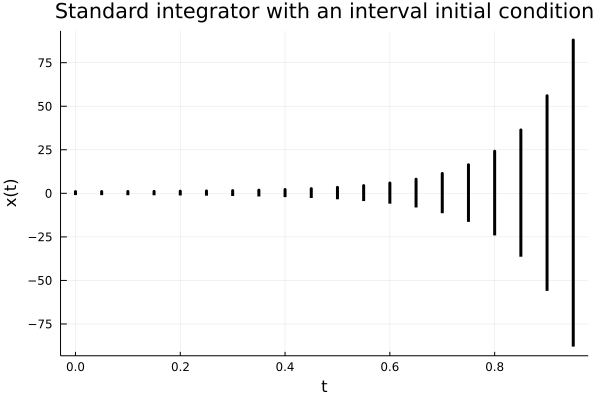

In [2]:
using LazySets, Plots
using LazySets: Interval

out = [Interval(sol.t[i]) × Interval(sol.u[i][1]) for i in 1:20]

plot(out, xlab="t", ylab="x(t)", lw=3.0, alpha=1., c=:black, marker=:none, lab="", title="Standard integrator with an interval initial condition")

On the contrary, specialized algorithms can handle this case without noticeable wrapping effect, producing a sequence of sets whose union covers the true solution for all initial points:

The corresponding solution using reachability analysis is computed next.

In [3]:
using ReachabilityAnalysis, Plots

# define the model (same as before)
function f(dx, x, p, t)
    dx[1] = -x[1] * sin(1.0 * t)
end

# define the set of initial states
X0 = -1 .. 1

# define the initial-value problem
prob = @ivp(x' = f(x), x(0) ∈ X0, dim=1)

# solve it
sol = solve(prob, alg=TMJets21a(abstol=1e-10), T=15);

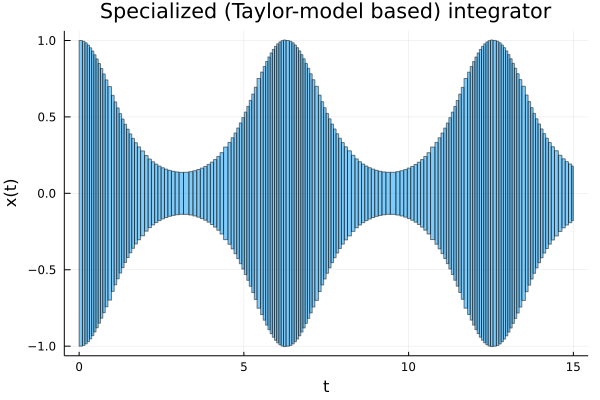

In [4]:
plot(sol, vars=(0, 1), xlab="t", ylab="x(t)", title="Specialized (Taylor-model based) integrator")

We can overlay exact solutions taken uniformly from the initial interval.

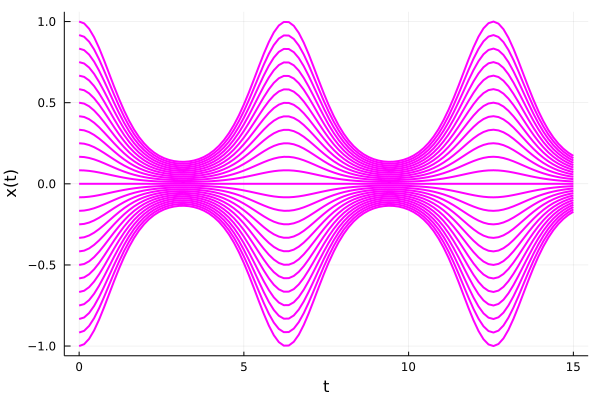

In [5]:
# it is illustrative to plot the computed flowpipe and the known analytic solution
# for a range of initial conditions that cover the range of `U0`.
analytic_sol(x0) = t -> x0 * exp(cos(t) - 1.0)

dt = range(0, 15, length=100)
x0vals = range(-1, 1, length=25)

fig = plot()
#plot!(fig, sol, vars=(0, 1), lw=0.0, title="Specialized (Taylor-model based) integrator")
[plot!(fig, dt, analytic_sol(x0).(dt), lab="", c=:magenta, lw=2.0, xlab="t", ylab="x(t)") for x0 in x0vals]; #!jl
fig

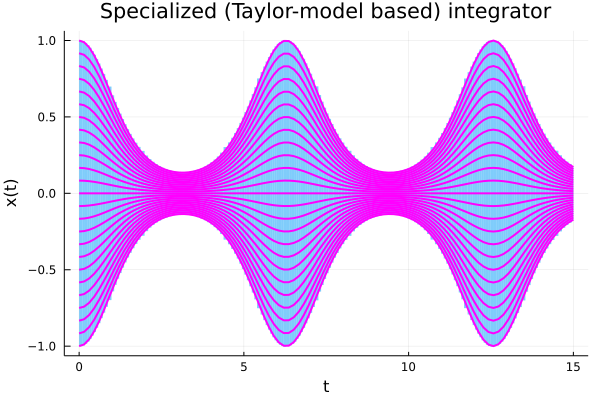

In [6]:
fig = plot()

plot!(fig, sol, lw=0.0, vars=(0, 1), xlab="t", ylab="x(t)", title="Specialized (Taylor-model based) integrator")
[plot!(fig, dt, analytic_sol(x0).(dt), lab="", c=:magenta, lw=2.0, xlab="t", ylab="x(t)") for x0 in x0vals]; #!jl
fig

In [7]:
# number of computed reach-sets
length(sol)

172

In [8]:
# reach-set representation
typeof(sol[1])

TaylorModelReachSet{Float64}

In [9]:
set(sol[1])

1-element Vector{TaylorModels.TaylorModel1{TaylorN{Float64}, Float64}}:
   1.0 x₁ + ( - 0.5 x₁) t² + ( 0.16666666666666666 x₁) t⁴ + ( - 0.04305555555555555 x₁) t⁶ + ( 0.009399801587301585 x₁) t⁸ + [-1.15691e-20, 1.15691e-20]

In [10]:
sol_univariate = deepcopy(sol); # for further use in this notebook

**Exercise.** Implement the single pendulum model with parameter variation in the physical constants and in the initial states as in [1]. You can plot numerical simulations on top of the flowpipe by passing the `ensemble=true`, `trajectories=xx` keyword arguments to the solver function, where `xx` is the number of desired trajectories, which are taken at random from the set of initial states.  

[1] https://mitmath.github.io/18337/lecture19/uncertainty_programming

## Taylor series and Taylor models

Taylor series are implemented in the Julia package TaylorSeries.jl, and Taylor models are implemented in the Julia package TaylorModels.jl.

Recommended material:

- JuliaCon 2018 talk by David P. Sanders and Luis Benet.

- Anoher great learning resource is: https://juliaintervals.github.io/ 

The JuliaIntervals site is maintained by [Luca Ferranti](https://github.com/lucaferranti), who is currently doing his Google Summer of Code on [IntervalLinearAlgebra.jl](https://github.com/lucaferranti/IntervalLinearAlgebra.jl/), under David's and Marcelo's supervision. Watch his lightning talk at JuliaCon!

In [11]:
using TaylorSeries
using IntervalArithmetic, TaylorModels, Plots

In [12]:
?Taylor1

search: Taylor1 set_taylor1_varname TaylorModel1 RTaylorModel1 TaylorN



```
Taylor1{T<:Number} <: AbstractSeries{T}
```

DataType for polynomial expansions in one independent variable.

**Fields:**

  * `coeffs :: Array{T,1}` Expansion coefficients; the $i$-th   component is the coefficient of degree $i-1$ of the expansion.
  * `order  :: Int` Maximum order (degree) of the polynomial.

Note that `Taylor1` variables are callable. For more information, see [`evaluate`](@ref).

---

```
Taylor1([T::Type=Float64], order::Int)
```

Shortcut to define the independent variable of a `Taylor1{T}` polynomial of given `order`. The default type for `T` is `Float64`.

```julia
julia> Taylor1(16)
 1.0 t + 𝒪(t¹⁷)

julia> Taylor1(Rational{Int}, 4)
 1//1 t + 𝒪(t⁵)
```


In [13]:
?TaylorN

search: TaylorN taylorinteg TaylorIntegration lyap_taylorinteg TaylorModelN



```
TaylorN{T<:Number} <: AbstractSeries{T}
```

DataType for polynomial expansions in many (>1) independent variables.

**Fields:**

  * `coeffs  :: Array{HomogeneousPolynomial{T},1}` Vector containing the

`HomogeneousPolynomial` entries. The $i$-th component corresponds to the homogeneous polynomial of degree $i-1$.

  * `order   :: Int`  maximum order of the polynomial expansion.

Note that `TaylorN` variables are callable. For more information, see [`evaluate`](@ref).

---

```
TaylorN([T::Type=Float64], nv::Int; [order::Int=get_order()])
```

Shortcut to define the `nv`-th independent `TaylorN{T}` variable as a polynomial. The order is defined through the keyword parameter `order`, whose default corresponds to `get_order()`. The default of type for `T` is `Float64`.

```julia
julia> TaylorN(1)
 1.0 x₁ + 𝒪(‖x‖⁷)

julia> TaylorN(Rational{Int},2)
 1//1 x₂ + 𝒪(‖x‖⁷)
```


Taylor models are implemented in the Julia package TaylorModels.jl

In [14]:
?TaylorModel1

search: TaylorModel1 RTaylorModel1 TaylorModelN TaylorModels TaylorModelReachSet



```
TaylorModel1{T,S}
```

Absolute Taylor model in 1 variable, providing a rigurous polynomial approximation given by a Taylor polynomial `pol` (around `x0`) and an absolute remainder `rem` for a function `f(x)` in one variable, valid in the interval `dom`. This corresponds to definition 2.1.3 of Mioara Joldes' thesis.

Fields:

  * `pol`: polynomial approximation, represented as `TaylorSeries.Taylor1`
  * `rem`: the interval bound
  * `x0` : expansion point
  * `dom`: domain, interval over which the Taylor model is defined / valid

The approximation $f(x) = p(x) + \Delta$ is satisfied for all $x\in \mathcal{D}$ ($0\in \Delta$); `n` is the order (degree) of the polynomial $p(x)=\sum_{i=0}^n p_i (x - x_0)^i$.


In [15]:
?TaylorModelN

search: TaylorModelN TaylorModel1 TaylorModels TaylorModelReachSet RTaylorModel1



```
TaylorModelN{N,T,S}
```

Taylor Models with absolute remainder for `N` independent variables.


A few examples follow:

In [16]:
using TaylorSeries

# expanding a function
taylor_expand(exp, 0, order=2)

 1.0 + 1.0 t + 0.5 t² + 𝒪(t³)

In [17]:
taylor_expand(t -> exp(cos(t) - 1), 0, order=6)

 1.0 - 0.5 t² + 0.16666666666666666 t⁴ - 0.04305555555555555 t⁶ + 𝒪(t⁷)

In [18]:
# expansion using a taylor series "variable"
t = Taylor1(6)

exp(t)

 1.0 + 1.0 t + 0.5 t² + 0.16666666666666666 t³ + 0.041666666666666664 t⁴ + 0.008333333333333333 t⁵ + 0.001388888888888889 t⁶ + 𝒪(t⁷)

In [19]:
exp(cos(t) - 1)

 1.0 - 0.5 t² + 0.16666666666666666 t⁴ - 0.04305555555555555 t⁶ + 𝒪(t⁷)

TaylorSeries.jl has many other features; see the documentation [TaylorSeries.jl](https://juliadiff.org/TaylorSeries.jl/latest/) for details.

We can also create Taylor series in many variables:

In [20]:
?set_variables

search: set_variables



```
set_variables([T::Type], names::String; [order=get_order(), numvars=-1])
```

Return a `TaylorN{T}` vector with each entry representing an independent variable. `names` defines the output for each variable (separated by a space). The default type `T` is `Float64`, and the default for `order` is the one defined globally. Changing the `order` or `numvars` resets the hash_tables.

If `numvars` is not specified, it is inferred from `names`. If only one variable name is defined and `numvars>1`, it uses this name with subscripts for the different variables.

```julia
julia> set_variables(Int, "x y z", order=4)
3-element Array{TaylorSeries.TaylorN{Int},1}:
  1 x + 𝒪(‖x‖⁵)
  1 y + 𝒪(‖x‖⁵)
  1 z + 𝒪(‖x‖⁵)

julia> set_variables("α", numvars=2)
2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 α₁ + 𝒪(‖x‖⁵)
  1.0 α₂ + 𝒪(‖x‖⁵)

julia> set_variables("x", order=6, numvars=2)
2-element Array{TaylorSeries.TaylorN{Float64},1}:
  1.0 x₁ + 𝒪(‖x‖⁷)
  1.0 x₂ + 𝒪(‖x‖⁷)
```


In [21]:
x, y = set_variables("x y", order=4)

2-element Vector{TaylorN{Float64}}:
  1.0 x + 𝒪(‖x‖⁵)
  1.0 y + 𝒪(‖x‖⁵)

In [22]:
typeof(x)

TaylorN{Float64}

In [23]:
dump(x)

TaylorN{Float64}
  coeffs: Array{HomogeneousPolynomial{Float64}}((5,)) HomogeneousPolynomial{Float64}[ 0.0,  1.0 x,  0.0,  0.0,  0.0]
  order: Int64 4


In [24]:
show_monomials(get_order(x))

 1  -->  x⁴
 2  -->  x³ y
 3  -->  x² y²
 4  -->  x y³
 5  -->  y⁴


In [25]:
aux = exp(cos(x) - cos(y) + sin(x*y) - 1)

 0.36787944117144233 - 0.18393972058572117 x² + 0.36787944117144233 x y + 0.18393972058572117 y² + 0.061313240195240384 x⁴ - 0.18393972058572117 x³ y + 0.09196986029286058 x² y² + 0.18393972058572117 x y³ + 0.030656620097620196 y⁴ + 𝒪(‖x‖⁵)

In [26]:
differentiate(aux, 1) # derivative wrt x

 - 0.36787944117144233 x + 0.36787944117144233 y + 0.24525296078096154 x³ - 0.5518191617571635 x² y + 0.18393972058572117 x y² + 0.18393972058572117 y³ + 𝒪(‖x‖⁵)

---

Let's consider some examples of Taylor models.

fT = f(tm) =  0.39484468326455857 - 0.393855592043663 t + 0.18246938526101011 t² + [-1.07944, 1.72355]
fT = f(tm) =  0.39484468326455857 - 0.393855592043663 t + 0.18246938526101011 t² + 0.014258580485865105 t³ + [-0.946548, 0.803778]
fT = f(tm) =  0.39484468326455857 - 0.393855592043663 t + 0.18246938526101011 t² + 0.014258580485865105 t³ - 0.054727422711077306 t⁴ + [-0.519518, 0.571084]
fT = f(tm) =  0.39484468326455857 - 0.393855592043663 t + 0.18246938526101011 t² + 0.014258580485865105 t³ - 0.054727422711077306 t⁴ + 0.024706768559030104 t⁵ + 0.0007709727046973829 t⁶ - 0.00520692104599662 t⁷ + 0.0019470348640809945 t⁸ + [-0.0410741, 0.0258577]


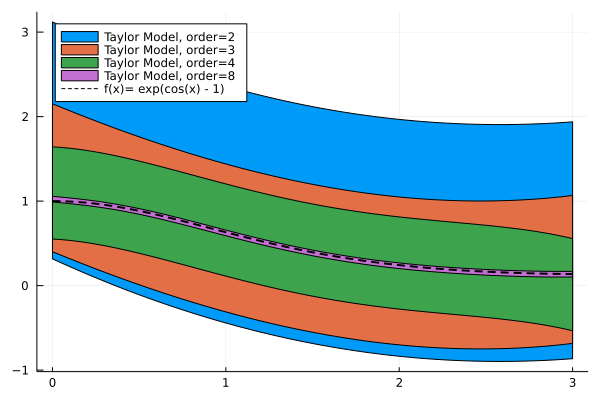

In [27]:
D = 0 .. 3 # Taylor Model domain
x0 = mid(D) # expansion point for the Taylor Series

f(x) = exp(cos(x) - 1)
xrange = range(D.lo, D.hi, length=100)

fig = plot(leg=:topleft)

for order in [2, 3, 4, 8]
    tm = TaylorModel1(order, x0, D) # create a Taylor Model "variable"
    @show fT = f(tm) # from evaluating this variable on f we get its Taylor Model
    plot!(fig, fT, label="Taylor Model, order=$order", alpha=1.)
end
plot!(xrange, x -> f(x), label="f(x)= exp(cos(x) - 1)", lw=2, c=:black, alpha=1., ls=:dash)

fig

-----

---

### Running example: Lotka-Volterra model

For the rest of this notebook, let's consider a two-dimensional textbook example: the Lotka-Volterra differential equations

The 2-dimensional Lotka-Volterra system depicts the populations change of a class of predators and a class of preys. The growth rate of preys’ population $x$ over time is given by

$$
    \frac{dx}{dt} = α x - β xy,
$$
where  $\alpha$, $\beta$ are constant parameters and $y$ is the population of predators.

 It gives that the number of preys grows exponentially without predation.

 The population growth of predators is governed by the differential equation

$$
 \frac{dy}{dt} = δ xy - γy,
$$
where  $\gamma, \delta$ are constant parameters.

We choose nominal parameter values to be $\alpha = 1.5, \beta = 1, \gamma = 3$ and $\delta = 1$.

In [28]:
using ReachabilityAnalysis, Plots

function lotkavolterra!(dx, x, params, t)
     α, β, γ, δ = params
    
    dx[1] = α * x[1] - β * x[1] * x[2]
    dx[2] = δ * x[1] * x[2] - γ * x[2]
    return dx
end

lotkavolterra! (generic function with 1 method)

Our reachability settings are chosen to be the initial set  $x\in [4.8,5.2], y \in [1.8,2.2]$ and a time horizon of $T = 5.0$.

In [29]:
X0 = (4.8 .. 5.2) × (1.8 .. 2.2)

prob = @ivp(x' = lotkavolterra!(x), dim=2, x(0) ∈ X0)

params = [1.5, 1.0, 3.0, 1.0] 
sol = solve(prob, T=8.0, alg=TMJets(), params=params);

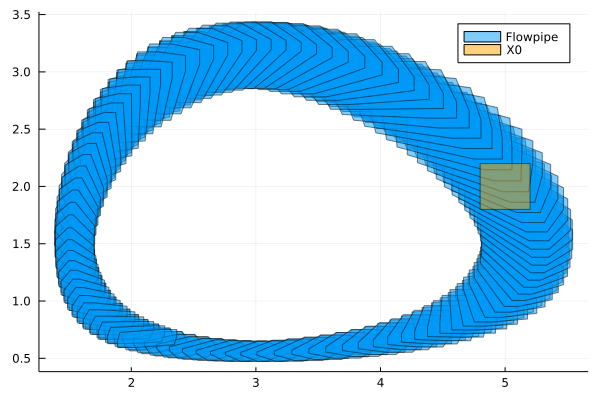

In [30]:
plot(sol, vars=(1, 2), lab="Flowpipe")
plot!(X0, c=:orange, lab="X0")

In this notebook we explore in more detail what is the way in which the solution is being represented here, and what is actually being plotted. We will see that the representation contains "more information" than just spatial information, and the above plot is just a simple enclosure of a more complex object.

### A note on reducing allocations with the `@taylorize` macro

Here, we describe the use of the macro @taylorize, which parses the functions containing the ODEs to be integrated, allowing to speed up taylorinteg and lyap_taylorinteg.

See the documentation page for [`@taylorize`](https://perezhz.github.io/TaylorIntegration.jl/latest/taylorize/#taylorize) of [TaylorIntegration.jl](https://github.com/PerezHz/TaylorIntegration.jl) for further details.

In [31]:
@time sol = solve(prob, T=8.0, alg=TMJets(), params=params);

  1.901546 seconds (22.72 M allocations: 1.915 GiB, 23.16% gc time)


In [32]:
@taylorize function lotkavolterra2!(dx, x, params, t)
     α, β, γ, δ = params
    
    aux = x[1] * x[2]

    dx[1] = α * x[1] - β * aux
    dx[2] = δ * aux - γ * x[2]
    return dx
end
prob = @ivp(x' = lotkavolterra2!(x), dim=2, x(0) ∈ X0)

InitialValueProblem{BlackBoxContinuousSystem{typeof(lotkavolterra2!)}, IntervalBox{2, Float64}}(BlackBoxContinuousSystem{typeof(lotkavolterra2!)}(lotkavolterra2!, 2), [4.79999, 5.20001] × [1.79999, 2.20001])

In [33]:
solve(prob, T=8.0, alg=TMJets(), params=params); # compile
@time solve(prob, T=8.0, alg=TMJets(), params=params);

  1.178525 seconds (18.58 M allocations: 1.575 GiB, 22.89% gc time)


Finer algorithmic tuning (orderT, orderQ, abstol, algorithm adaptivity and error control, etc), also affects performance, but that would take us too far.

In [34]:
sol_lotka_volterra = deepcopy(sol);

In [35]:
sol_lotka_volterra_zono = overapproximate(sol_lotka_volterra, Zonotope);

In [36]:
numrsets(sol_lotka_volterra)

253

---

## Taylor model reach-set representation

In [37]:
R = sol[10];

tspan(R)

[0.189544, 0.209256]

In [38]:
typeof(R)

TaylorModelReachSet{Float64}

This is a representation in space-time: it is a taylor model expansion in one variable (namely, "time") whose coefficients are taylor series in several variables (namely, "space").

In [39]:
X = set(R)

typeof(X)

Vector{TaylorModel1{TaylorN{Float64}, Float64}} (alias for Array{TaylorModel1{TaylorN{Float64}, Float64}, 1})

In [40]:
length(X)

2

In [41]:
X[1]

  4.232251362425008 + 0.13406913390659228 x₁ - 0.17853776309408836 x₂ - 0.0016197760264177173 x₁² - 0.00828701709971265 x₁ x₂ + 0.00478234493793006 x₂² + ( - 5.246619435733793 - 0.5493560344832664 x₁ - 0.7325396844671168 x₂ - 0.01524952784400669 x₁² - 0.025705659875745614 x₁ x₂ + 0.04962636911994489 x₂²) t + ( - 3.891921629163775 - 0.6616381765606119 x₁ + 1.794038158363561 x₂ - 0.011321818553319046 x₁² + 0.2002942935029339 x₁ x₂ + 0.0822133876180188 x₂²) t² + ( 14.71708012481403 + 2.735942246326561 x₁ + 2.5603746785171464 x₂ + 0.18493582295282715 x₁² + 0.37622438284535664 x₁ x₂ - 0.4520114591406546 x₂²) t³ + ( 4.252053872827882 + 1.6634675792502054 x₁ - 7.835556256468585 x₂ + 0.14130326087778985 x₁² - 1.5379414118457744 x₁ x₂ - 0.7899484979556565 x₂²) t⁴ + ( - 35.50089397413028 - 10.158851212362482 x₁ - 7.272424535942584 x₂ - 1.1538498632725538 x₁² - 2.0842891578752014 x₁ x₂ + 2.635486088680035 x₂²) t⁵ + ( - 3.0771417607243414 - 3.717493340248494 x₁ + 27.953744168521357 x₂ - 0.66980283

When we plot we evaluate the range of this object, which is an optimization problem. Since we are often interested in obtaining a global solution, we use interval arithmetic.

Other methods exist: affine arithmetic, Taylor model range bounders, polynomial optimization via SOS, Bernstein expansions, are other fast global optimization methods used frequently.

Plotting consists of evaluating the range of those objects; it is thus a nonlinear polynomial optimization problem.

  0.296419 seconds (503.06 k allocations: 32.766 MiB, 98.85% compilation time)
  0.698280 seconds (1.06 M allocations: 65.746 MiB, 98.02% compilation time)


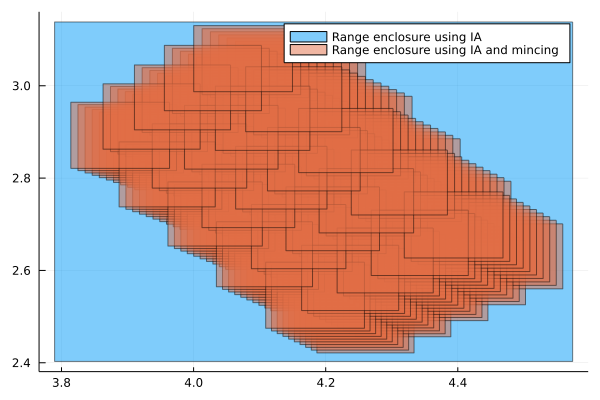

In [42]:
@time H = overapproximate(R, Hyperrectangle)

@time Hsplit = overapproximate(R, Hyperrectangle, ntdiv=10, nsdiv=5)

plot(H, vars=(1, 2), lab="Range enclosure using IA")
plot!(Hsplit, vars=(1, 2), lab="Range enclosure using IA and mincing")

  1.502526 seconds (1.54 M allocations: 89.283 MiB, 99.67% compilation time)


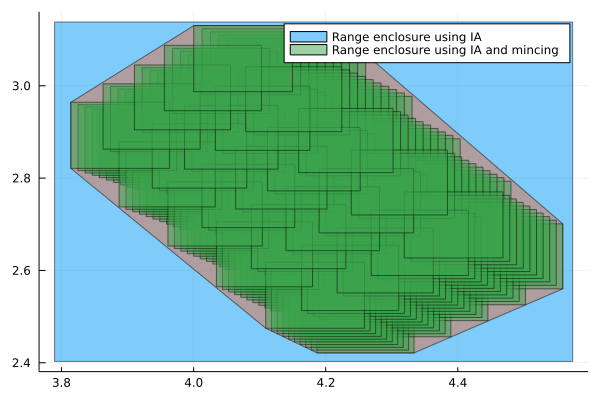

In [43]:
@time Hpoly = overapproximate(set(convexify(Hsplit)), HPolygon, 1e-3);

plot(H, vars=(1, 2), lab="Range enclosure using IA")
plot!(Hpoly)
plot!(Hsplit, vars=(1, 2), lab="Range enclosure using IA and mincing")

Spatial variables are normalized in the $[-1, 1]^n$ interval, and the Taylor model in time has its domain normalized (starts at zero).

In [44]:
tspan(R) # time domain of the reach-set (= in the context of the whole flowpipe)

[0.189544, 0.209256]

In [45]:
domain(R) # domain of the polynomial expansion

[0, 0.019711]

<div style="background: ghostwhite; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;
            font-family: helvetica;">

**Taylor model reach-sets.** Summary of important concepts.

1. Taylor model reach-sets represent sets in *space-time*: it is a Taylor model expansion in *time* whose coefficients are multivariate polynomials in *space*.

2. Plotting consists of evaluating the range of those objects; it is thus a nonlinear polynomial optimization problem.

3. Inteval arithmetic offers a very efficient, and also gloal, solution, but the result is generally coarse if we don't split. 

4. To reduce the range approximation error, either split the time and space domain (or both), and keep the linear dependencies between variables (i.e. use zonotopes).

5. Spatial variables are normalized to the symmetric interval box $[-1, 1]^n$ (useful: `ReachabilityAnalysis.symBox(n)`)

6. The time domain is always normalized (i.e. starting at `0`, so expect a difference between `tspan(R)` and `domain(R)`).

</div>

## Evaluation and overapproximation

  0.000163 seconds (1.22 k allocations: 99.422 KiB)
  0.011467 seconds (118.68 k allocations: 5.741 MiB)


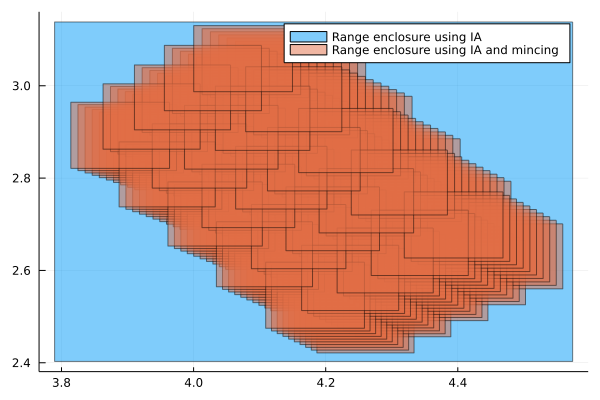

In [46]:
@time H = overapproximate(R, Hyperrectangle)

@time Hsplit = overapproximate(R, Hyperrectangle, ntdiv=10, nsdiv=5)

plot(H, vars=(1, 2), lab="Range enclosure using IA")
plot!(Hsplit, vars=(1, 2), lab="Range enclosure using IA and mincing")

Such union of boxes describe in general a non-convex set. In some cases it suffices to work with a polytopic (ie. convex) approximation.

  0.000552 seconds (10.06 k allocations: 948.578 KiB)


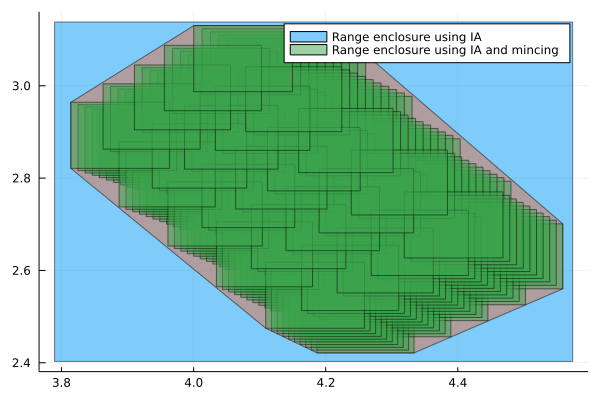

In [47]:
@time Hpoly = overapproximate(set(convexify(Hsplit)), HPolygon, 1e-3);

plot(H, vars=(1, 2), lab="Range enclosure using IA")
plot!(Hpoly)
plot!(Hsplit, vars=(1, 2), lab="Range enclosure using IA and mincing")

In [48]:
@show length(Hsplit)

length(Hsplit) = 250


250

In [49]:
@show length(constraints_list(Hpoly))

length(constraints_list(Hpoly)) = 11


11

Evaluation with interval arithmetic disregards the linear relations between variables.

We can keep that part using evaluation with zonotopes.

  0.000219 seconds (2.30 k allocations: 190.656 KiB)
  0.000141 seconds (1.22 k allocations: 99.422 KiB)
  0.012490 seconds (118.68 k allocations: 5.741 MiB)


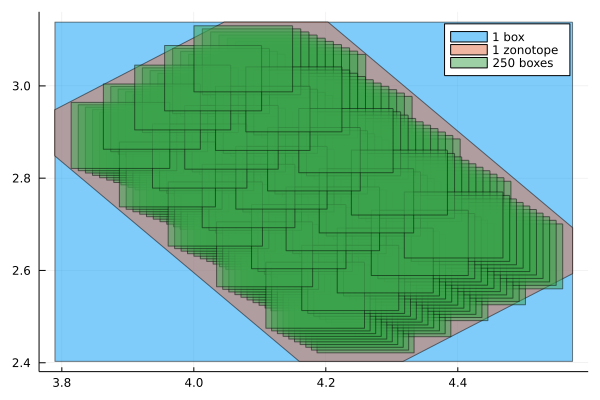

In [50]:
@time Z = overapproximate(R, Zonotope)

@time H = overapproximate(R, Hyperrectangle)

@time Hsplit = overapproximate(R, Hyperrectangle, ntdiv=10, nsdiv=5)

plot(H, vars=(1, 2), lab="1 box")
plot!(Z, vars=(1, 2), lab="1 zonotope")
plot!(Hsplit, vars=(1, 2), lab="250 boxes")

We can evaluate in time:

In [51]:
R

TaylorModelReachSet{Float64}(TaylorModel1{TaylorN{Float64}, Float64}[  4.232251362425008 + 0.13406913390659228 x₁ - 0.17853776309408836 x₂ - 0.0016197760264177173 x₁² - 0.00828701709971265 x₁ x₂ + 0.00478234493793006 x₂² + ( - 5.246619435733793 - 0.5493560344832664 x₁ - 0.7325396844671168 x₂ - 0.01524952784400669 x₁² - 0.025705659875745614 x₁ x₂ + 0.04962636911994489 x₂²) t + ( - 3.891921629163775 - 0.6616381765606119 x₁ + 1.794038158363561 x₂ - 0.011321818553319046 x₁² + 0.2002942935029339 x₁ x₂ + 0.0822133876180188 x₂²) t² + ( 14.71708012481403 + 2.735942246326561 x₁ + 2.5603746785171464 x₂ + 0.18493582295282715 x₁² + 0.37622438284535664 x₁ x₂ - 0.4520114591406546 x₂²) t³ + ( 4.252053872827882 + 1.6634675792502054 x₁ - 7.835556256468585 x₂ + 0.14130326087778985 x₁² - 1.5379414118457744 x₁ x₂ - 0.7899484979556565 x₂²) t⁴ + ( - 35.50089397413028 - 10.158851212362482 x₁ - 7.272424535942584 x₂ - 1.1538498632725538 x₁² - 2.0842891578752014 x₁ x₂ + 2.635486088680035 x₂²) t⁵ + ( - 3.0771417

In [52]:
X = set(R)

p = X[1]

  4.232251362425008 + 0.13406913390659228 x₁ - 0.17853776309408836 x₂ - 0.0016197760264177173 x₁² - 0.00828701709971265 x₁ x₂ + 0.00478234493793006 x₂² + ( - 5.246619435733793 - 0.5493560344832664 x₁ - 0.7325396844671168 x₂ - 0.01524952784400669 x₁² - 0.025705659875745614 x₁ x₂ + 0.04962636911994489 x₂²) t + ( - 3.891921629163775 - 0.6616381765606119 x₁ + 1.794038158363561 x₂ - 0.011321818553319046 x₁² + 0.2002942935029339 x₁ x₂ + 0.0822133876180188 x₂²) t² + ( 14.71708012481403 + 2.735942246326561 x₁ + 2.5603746785171464 x₂ + 0.18493582295282715 x₁² + 0.37622438284535664 x₁ x₂ - 0.4520114591406546 x₂²) t³ + ( 4.252053872827882 + 1.6634675792502054 x₁ - 7.835556256468585 x₂ + 0.14130326087778985 x₁² - 1.5379414118457744 x₁ x₂ - 0.7899484979556565 x₂²) t⁴ + ( - 35.50089397413028 - 10.158851212362482 x₁ - 7.272424535942584 x₂ - 1.1538498632725538 x₁² - 2.0842891578752014 x₁ x₂ + 2.635486088680035 x₂²) t⁵ + ( - 3.0771417607243414 - 3.717493340248494 x₁ + 27.953744168521357 x₂ - 0.66980283

In [53]:
evaluate(p, domain(R)) # whole time span

 [4.12732, 4.23226] + [0.122983, 0.13407] x₁ + [-0.192977, -0.17784] x₂ + [-0.00192476, -0.00161977] x₁² + [-0.00879371, -0.00820919] x₁ x₂ + [0.00478234, 0.00579247] x₂² + 𝒪(‖x‖³)

In [54]:
evaluate(p, sup(domain(R))) # final time

 [4.12743, 4.12744] + [0.123004, 0.123005] x₁ + [-0.192262, -0.192261] x₂ + [-0.00192333, -0.00192332] x₁² + [-0.00871324, -0.00871323] x₁ x₂ + [0.00578889, 0.0057889] x₂² + 𝒪(‖x‖³)

In [55]:
g = evaluate(p, mid(domain(R))) # intermediate time

 [4.18017, 4.18018] + [0.128593, 0.128594] x₁ + [-0.185581, -0.18558] x₂ + [-0.00177099, -0.00177098] x₁² + [-0.00852056, -0.00852055] x₁ x₂ + [0.00527898, 0.00527899] x₂² + 𝒪(‖x‖³)

In all cases we obtain a multivariate Taylor series whose coefficients are *intervals.*

We can further evaluate that polynomial in space, remembering that by construction, the `TaylorModelReachSet` has its spatial variables normalized in the $[-1, 1]^n$ domain.

In [56]:
g = evaluate(p, mid(domain(R)))

 [4.18017, 4.18018] + [0.128593, 0.128594] x₁ + [-0.185581, -0.18558] x₂ + [-0.00177099, -0.00177098] x₁² + [-0.00852056, -0.00852055] x₁ x₂ + [0.00527898, 0.00527899] x₂² + 𝒪(‖x‖³)

In [57]:
using ReachabilityAnalysis: symBox

S2 = symBox(2)

[-1, 1] × [-1, 1]

In [58]:
evaluate(g, S2) # range enclosure in its full domain

[3.85571, 4.50816]

In [59]:
evaluate(g, mid(S2)) # evaluate at a point

[4.18017, 4.18018]

In [60]:
# evalute at a subset
evaluate(g, interval(0.5, 0.9) × interval(-0.1, 0.1))

[4.22371, 4.31485]

### How does evaluation with a zonotope work?

It is simpler to reason about the converse. Suppose that we have a zonotope of order 1.

In [61]:
import Random

Random.seed!(11)

Z = rand(Zonotope, dim=2, num_generators=2)

c = LazySets.center(Z)

2-element Vector{Float64}:
 0.6832522090529809
 0.30163472599685565

In [62]:
G = genmat(Z)

2×2 Matrix{Float64}:
 -1.90288   1.02409
  1.99846  -0.318283

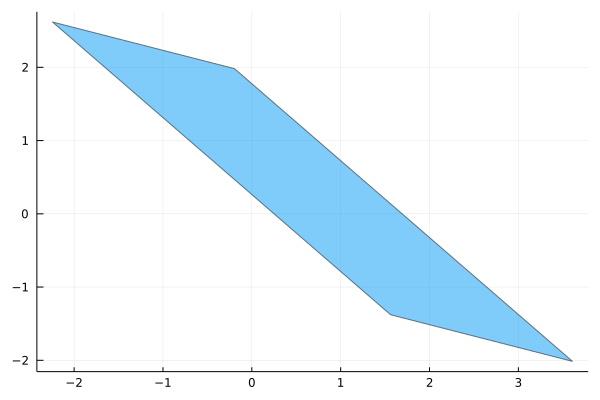

In [63]:
plot(Z)

In [64]:
T = convert(TaylorModelReachSet, Z)

TaylorModelReachSet{Float64}(TaylorModel1{TaylorN{Float64}, Float64}[  0.6832522090529809 - 1.9028765702202013 x₁ + 1.024092985089936 x₂ + [0, 0],   0.30163472599685565 + 1.9984570991198647 x₁ - 0.31828253809640206 x₂ + [0, 0]], [0, 0])

In [65]:
set(T)

2-element Vector{TaylorModel1{TaylorN{Float64}, Float64}}:
      0.6832522090529809 - 1.9028765702202013 x₁ + 1.024092985089936 x₂ + [0, 0]
   0.30163472599685565 + 1.9984570991198647 x₁ - 0.31828253809640206 x₂ + [0, 0]

Observe that the Taylor model is such that:

- the center of the zonotope matches the independent polynomial terms

- the linear coefficients match the columns of the generators matrix

- the remainder terms are *zero*

In [66]:
c

2-element Vector{Float64}:
 0.6832522090529809
 0.30163472599685565

In [67]:
G

2×2 Matrix{Float64}:
 -1.90288   1.02409
  1.99846  -0.318283

Converting from a Taylor model reach-set to a zonotope works by  such that we keep the linear terms intact and we evaluate the remainder terms.

In [68]:
# recover the original zonotope
overapproximate(T, Zonotope)

ReachSet{Float64, Zonotope{Float64, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}}(Zonotope{Float64, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}([0.6832522090529809, 0.30163472599685565], 
 -1.90288   1.02409
  1.99846  -0.318283), [0, 0])

Let's assume that we are given a Taylor model reach-set with non-zero remainder.

In [69]:
X = set(T)

2-element Vector{TaylorModel1{TaylorN{Float64}, Float64}}:
      0.6832522090529809 - 1.9028765702202013 x₁ + 1.024092985089936 x₂ + [0, 0]
   0.30163472599685565 + 1.9984570991198647 x₁ - 0.31828253809640206 x₂ + [0, 0]

In [70]:
p1 = X[1]
p2 = X[2]

rem_modif = interval(-1e-1, 1e-1)
p1_modif = TaylorModel1(Taylor1(p1.pol), rem_modif, p1.x0, p1.dom)
p2_modif = TaylorModel1(Taylor1(p2.pol), 2rem_modif, p2.x0, p2.dom)

T_modif = TaylorModelReachSet([p1_modif, p2_modif], interval(0))

X_modif = set(T_modif)

2-element Vector{TaylorModel1{TaylorN{Float64}, Float64}}:
      0.6832522090529809 - 1.9028765702202013 x₁ + 1.024092985089936 x₂ + [-0.100001, 0.100001]
   0.30163472599685565 + 1.9984570991198647 x₁ - 0.31828253809640206 x₂ + [-0.200001, 0.200001]

In [71]:
Z_modif = overapproximate(T_modif, Zonotope)

ReachSet{Float64, Zonotope{Float64, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}}(Zonotope{Float64, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}([0.6832522090529809, 0.30163472599685565], 
 -1.90288   1.02409   0.1   ⋅ 
  1.99846  -0.318283   ⋅   0.2), [0, 0])

This conversion is also exact! See how the remainder terms appear in a diagonal matrix at columns 3 and 4. That is because the zonotope can stack more than $n$ generators. The zonotope order is 2 in this case:

$$
\textrm{Zonotope order} = \dfrac{\textrm{num generators}}{\textrm{dimension}} = \dfrac{\textrm{num columns}}{\textrm{num rows}}
$$

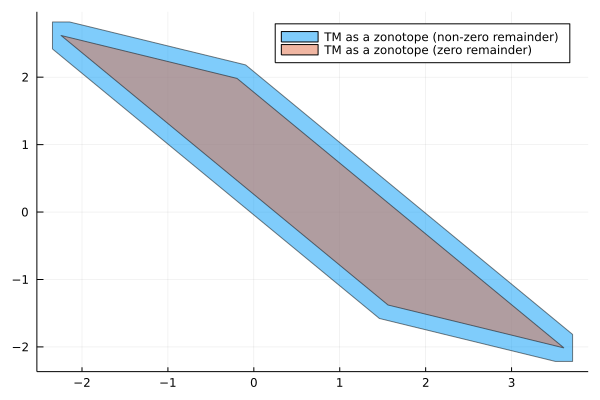

In [72]:
plot(Z_modif, vars=(1, 2), lab="TM as a zonotope (non-zero remainder)")
plot!(Z, lab="TM as a zonotope (zero remainder)")

Let's now consider converting a Taylor model with higher order terms to a zonotope.

In [73]:
p1 = X[1]
p2 = X[2]

p1_modif = TaylorModel1(Taylor1(p1.pol^2), p1.rem, p1.x0, p1.dom)
p2_modif = TaylorModel1(Taylor1(p2.pol^2), p2.rem, p2.x0, p2.dom)

T_modif = TaylorModelReachSet([p1_modif, p2_modif], interval(0))

X_modif = set(T_modif)

2-element Vector{TaylorModel1{TaylorN{Float64}, Float64}}:
   0.46683358117577833 - 2.6002892403162243 x₁ + 1.3994275886767205 x₂ + 3.6209392414929966 x₁² - 3.8974450941090106 x₁ x₂ + 1.048766442110416 x₂² + [0, 0]
   0.09098350792719818 + 1.2056081190189827 x₁ - 0.192010132336584 x₂ + 3.9938307770225845 x₁² - 1.272147995569287 x₁ x₂ + 0.10130377405708763 x₂² + [0, 0]

In [74]:
Z_modif = overapproximate(T_modif, Zonotope)

ReachSet{Float64, Zonotope{Float64, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}}(Zonotope{Float64, Vector{Float64}, SparseArrays.SparseMatrixCSC{Float64, Int64}}([2.801686422977485, 2.1385507834670348], 
 -2.60029   1.39943  6.2323   ⋅ 
  1.20561  -0.19201   ⋅      3.31972), [0, 0])

This conversion is not exact: while the linear terms are handled exactly, the nonlinear ones are stack into a diagonal submatrix of the zonotope.

In [75]:
aux1 = p1.pol^2

  0.46683358117577833 - 2.6002892403162243 x₁ + 1.3994275886767205 x₂ + 3.6209392414929966 x₁² - 3.8974450941090106 x₁ x₂ + 1.048766442110416 x₂² + 𝒪(‖x‖³) + 𝒪(t⁹)

In [76]:
aux2 = aux1.coeffs[1]

 0.46683358117577833 - 2.6002892403162243 x₁ + 1.3994275886767205 x₂ + 3.6209392414929966 x₁² - 3.8974450941090106 x₁ x₂ + 1.048766442110416 x₂² + 𝒪(‖x‖³)

In [77]:
aux3 = nonlinear_polynomial(aux2)

 3.6209392414929966 x₁² - 3.8974450941090106 x₁ x₂ + 1.048766442110416 x₂² + 𝒪(‖x‖³)

In [78]:
rr = evaluate(aux3, symBox(2))

[-3.89745, 8.56716]

In [79]:
diam(rr) / 2.

6.232297935910718

As a final note: not all zonotopes can be converted to a Taylor models using these ideas, since zonotopes can have any order > 2. However, zonotopes with *some* structure can be converted to Taylor models exactly, in particular when we can map some generators to remainder terms. This method is used in the `NeuralNetworkAnalysis.jl` package.

## Construction and propagation

The Taylor model reach-set representation has a lot of expressive power.

We can pass a "manually" constructed reach-set to the reachability solver. This is particularly useful for dynamics that mix continuous and discrete behaviors (hybrid systems).

<div style="background: ghostwhite; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;
            font-family: helvetica;">

**Algorithmic scheme for reachability using Taylor models.**

*Input:* Differential equation $x'(t) = f(x, t)$, initial Taylor model reach-set, order of the expansion in time (`orderT`) and in space (`orderQ`); absolte tolerance (`abstol`); final time horizon $T$.

*Output:* Flowpipe consisting of the union of Taylor model reach-sets.

1. Obtain a non-validated solution, using TaylorIntegration.jl, of the integral equation:

$$
x(t) = x_0 + \int_{t_0}^t f(s, x(s)) ds := K(x(t)),
$$
where $K$ is the associated Picard integral operator, so we have restated the problem as finding a fixed point on a function space.

By operator theory (Schauder's fixed point theory): to validate the solution we need a Taylor model $(P, \Delta_P)$ such that $K(P + \Delta_P) \subseteq P + \Delta_P$. The natural extension of the Picard integral operator to Taylor models is:

$$
K(P + \Delta_P) = (Q + \Delta_Q) + \int_{t_0}^t f(ds, P + \Delta_P) ds \qquad (1)
$$

2. Compute the polynomial part of the solution of (1) and iterate with the Picard operator until the condition $K(P + \Delta_P)  \subseteq P + \Delta_P$ holds.

3. Generate a new Taylor model initial condition as $(P + \Delta)(\delta t)$ for the next integration step.

4. Repeat from 2 until the final time horizon $T$.
</div>

The scheme presented above has been implemented and refined by Luis Benet and Uziel Linares (JuliaLang GSOC, 2020, supervised by Luis and myself).

### Example: propagating a non-convex set

In [80]:
TMJets()

TMJets21b{Float64, ZonotopeEnclosure}
  orderQ: Int64 2
  orderT: Int64 8
  abstol: Float64 1.0e-10
  maxsteps: Int64 2000
  absorb: Bool false
  adaptive: Bool true
  minabstol: Float64 1.0e-50
  validatesteps: Int64 30
  ε: Float64 1.0e-10
  δ: Float64 1.0e-6
  absorb_steps: Int64 3
  disjointness: ZonotopeEnclosure ZonotopeEnclosure()


Recall our Lotka-Volterra example with initial condition:

In [81]:
X0 = (4.8 .. 5.2) × (1.8 .. 2.2)

[4.79999, 5.20001] × [1.79999, 2.20001]

Let's make a parabola inside $X_0$.

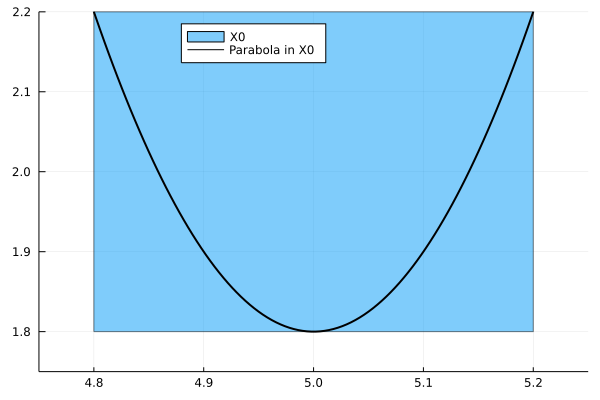

In [82]:
plot(X0, lab="X0", legend=:top)
plot!(range(4, 6, length=500), x -> 10x^2 - 100x + 251.8, c=:black, lw=2.0, lab="Parabola in X0")
xlims!(4.75, 5.25)
ylims!(1.75, 2.2)

Now we need to **renormalize** the parabola to the symmetric interval $[-1, 1]^2$.

In [83]:
orderQ = 2
orderT = 8

x = set_variables("x y", order=orderQ)

p1 = 5.2 + 0.2(x[1] - 1)
p2 = 0.4*x[1]^2 + 1.8

remm = t0 = tdom = interval(0)

S = [TaylorModel1(Taylor1(pol, orderT), remm, t0, tdom) for pol in [p1, p2]]
T0 = TaylorModelReachSet(S, interval(0));

H = overapproximate(T0, Hyperrectangle, ntdiv=1, nsdiv=100)

plot(X0, leg=:top, lab="X0")
plot!(H, vars=(1, 2), c=:orange, lab="Parabola (normalized TM)")
plot!(range(4, 6, length=500), x -> 10x^2 - 100x + 251.8, c=:black, lw=2.0, lab="")

xlims!(4.75, 5.25)
ylims!(1.75, 2.2)

In [84]:
prob = @ivp(x' = lotkavolterra!(x), dim=2, x(0) ∈ T0)

params = [1.5, 1.0, 3.0, 1.0] 
sol_para = solve(prob, T=8.0, alg=TMJets(orderQ=orderQ, orderT=orderT), params=params);

In [85]:
numrsets(sol_para)

255

In [86]:
Hpara = [overapproximate(R, Hyperrectangle, ntdiv=10, nsdiv=30) for R in sol_para[1:10]];

In [87]:
# uncomment to generate new plot
#fig = plot(title="Propagation of parabola through the L-V equations")
#[plot!(fig, Hpara[i], vars=(1, 2), lw=0.0) for i in 1:10];
#fig

<img src="pics/lv_parabola_1.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/lv_parabola_all.png" alt="Drawing" style="width: 600px;"/>

Again it should be remarked that the reason we see the boxes is simply for ease of visualization (or lack of better, higher order global approximators of the Taylor models reach-set). We can see this by inspecting the Taylor model:

In [88]:
sol_para[50]

TaylorModelReachSet{Float64}(TaylorModel1{TaylorN{Float64}, Float64}[  1.5908634532886914 - 0.09015844869417054 x₁ - 0.06836138469181034 x₁² + ( 0.035875937533876634 + 0.012610197497005954 x₁ + 0.37987834396491177 x₁²) t + ( 1.6564353506501086 + 0.0020934584276193387 x₁ - 0.25757253043997236 x₁²) t² + ( - 0.7545631861734865 - 0.039376157290247744 x₁ + 0.3336611514118925 x₁²) t³ + ( 0.8089331353915212 + 0.10312547599861954 x₁ - 0.16468520994748356 x₁²) t⁴ + ( - 0.43716489397100416 - 0.11310396001030645 x₁ - 0.03653781403805364 x₁²) t⁵ + ( 0.084465457964546 + 0.10870962847971644 x₁ + 0.2323958940350728 x₁²) t⁶ + ( 0.17481963866527592 - 0.06423536570933018 x₁ - 0.3672992523186837 x₁²) t⁷ + ( - 0.3390174606855778 + 0.006600097599331906 x₁ + 0.3800852377033884 x₁²) t⁸ + [-1.68379e-10, 1.68547e-10],   1.477448763776858 - 0.009204675574606275 x₁ - 0.2402782314094755 x₁² + ( - 2.0819270489314143 - 0.12023384381444294 x₁ + 0.23841427322579922 x₁²) t + ( 1.4933621758974207 + 0.18771495541679956 

### Example: parametric reachability

It is possible to model uncertain parameters with a prescribed dynamics by adding them to the differential equation as a new state variable. The simplest case is to consider parameters which are constant in time.

In [89]:
@taylorize function lotkavolterra_parametric(dx, x, params, t)
    α = x[3]
    β = x[4]
    γ = x[5]
    δ = x[6]
    
    aux = x[1] * x[2]
    dx[1] = α * x[1] - β * aux
    dx[2] = δ * aux - γ * x[2]

    # encode uncertain
    dx[3] = zero(α)
    dx[4] = zero(α)
    dx[5] = zero(α)
    dx[6] = zero(α)
end

Suppose that we bloat all parameters by $0.01$.

In [90]:
p0 = [1.5, 1.0, 3.0, 1.0] 

p_int = Singleton(p0) ⊕ BallInf(zeros(4), 0.01)
 
X0 = Hyperrectangle(low=[4.8, 1.8], high=[5.2, 2.2])
X0_params = convert(Hyperrectangle, X0) × box_approximation(p_int)

prob = @ivp(x' = lotkavolterra_parametric(x), dim: 6, x(0) ∈ X0_params)

sol_params = solve(prob, tspan=(0.0, 8.0), alg=TMJets());

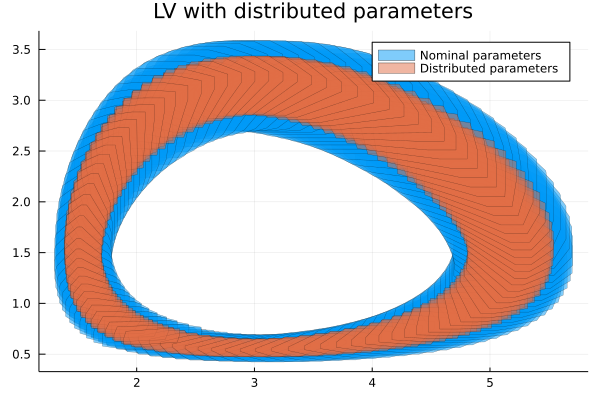

In [91]:
fig = plot(title="LV with distributed parameters")
plot!(fig, sol_params, vars=(1, 2), lw=0.3, lab="Nominal parameters")
plot!(fig, sol_lotka_volterra_zono, vars=(1, 2), lw=0.3, lab="Distributed parameters")

The solution's expression contains the parameters $x_3$ to $x_6$:

In [92]:
set(sol_params[1])[4]

  1.0 + 0.010000000000000009 x₄ + [0, 0]

In [93]:
set(sol_params[1])[1]

  5.0 + 0.20000000000000018 x₁ + ( - 2.5 - 0.10000000000000009 x₁ - 1.0000000000000009 x₂ + 0.050000000000000044 x₃ - 0.10000000000000009 x₄ - 0.04000000000000007 x₁ x₂ + 0.0020000000000000035 x₁ x₃ - 0.004000000000000007 x₁ x₄ - 0.010000000000000018 x₂ x₄) t + ( - 9.375 - 1.3750000000000013 x₁ - 0.5000000000000004 x₂ - 0.025000000000000022 x₃ - 0.050000000000000044 x₄ + 0.049999999999998934 x₅ - 0.2500000000000002 x₆ - 0.04000000000000007 x₁² - 0.1200000000000002 x₁ x₂ - 0.0010000000000000018 x₁ x₃ - 0.012000000000000021 x₁ x₄ + 0.0019999999999999593 x₁ x₅ - 0.020000000000000035 x₁ x₆ + 0.10000000000000017 x₂² - 0.010000000000000018 x₂ x₃ + 0.015000000000000027 x₂ x₄ + 0.004999999999999899 x₂ x₅ - 0.025000000000000043 x₂ x₆ + 0.00025000000000000044 x₃² - 0.0010000000000000018 x₃ x₄ + 0.0010000000000000018 x₄² + 0.0004999999999999898 x₄ x₅ - 0.0025000000000000044 x₄ x₆) t² + ( 2.3958333333333335 - 0.5708333333333337 x₁ + 3.79166666666667 x₂ - 0.17708333333333348 x₃ + 0.3791666666666670

Therefore we can infer information from evaluating this reach-set on parameter subsets. With this computation, we haver propagated the full parameter space, i.e. a dense subset of $\mathbb{R}^4$, through the given ODEs.

## Example notebooks for further exploration

## Invariant set computation (*Van der Pol model*)

<img src="pics/vanderpol_1.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/vanderpol_5.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/vanderpol_6.png" alt="Drawing" style="width: 600px;"/>

<div style="background: lightgreen; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;
            font-family: helvetica;">

See the full notebook at: https://nbviewer.jupyter.org/github/JuliaReach/ReachabilityAnalysis.jl/blob/gh-pages/dev/models/VanDerPol.ipynb
    
    
 For a more difficult model of coupled Van der Pol equations, see ARCH-COMP 2021 Proceedings (NLN).
 
</div>

## Verification of quadrotor stabilization (*Quadrotor model*)

<img src="pics/quadrotor_0.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/quadrotor_1.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/quadrotor_2.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/quadrotor_3.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/quadrotor_4.png" alt="Drawing" style="width: 600px;"/>

<img src="pics/quadrotor_6.png" alt="Drawing" style="width: 600px;"/>

<div style="background: lightgreen; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;
            font-family: helvetica;">

See the full notebook at: https://juliareach.github.io/ReachabilityAnalysis.jl/dev/models/Quadrotor/

Text: ARCH-COMP 2020 Proceedings (NLN category).
</div>

## Safety verification in a nonlinear hybrid system (*Spacecraft rendez-vous*)

- Spacecraft rendezvous is a perfect use case for formal veriﬁcation of hybrid systems with nonlinear dynamics since **mission failure can cost lives** and is **extremely expensive.**

- The nonlinear dynamic equations describe the two-dimensional, planar motion of the space-
craft on an orbital plane towards a space station.

<img src="pics/spacecraft_3.png" alt="Drawing" style="width: 800px;"/>

<img src="pics/quadrotor_2.png" alt="Drawing" style="width: 400px;"/>

<img src="pics/spacecraft_1.png" alt="Drawing" style="width: 600px;"/>

<div style="background: lightgreen; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;
            font-family: helvetica;">

See: https://juliareach.github.io/ReachabilityAnalysis.jl/dev/models/Spacecraft/ 

See also: ARCH-COMP 2021 Proceedings (NLN category) (to be published).
    
</div>

## What comes next?

In the final part of this workshop we present NeuralNewtorkAnalysis.jl, a project that aims at **combining nonlinear reachability** with **set propagation through neural networks.**